In [1]:
!pip install fairseq
!pip install sentencepiece
!pip install sacremoses
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 24.1 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 15.2 MB/s eta 0:00:00
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=10416014 sha256=ca95177ddadb083ba2e4f3b362db801ee7a3e0f31cccb6c4dfd479a714093207
  Stored in directory: /root/.cache/pip/wheels/e4/35/55/9c66f65ec7c83fd6fbc2b9502a0ac81b2448a1196159dacc32
  Created wheel

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from urllib.request import urlretrieve
import zipfile
import os
import shutil

import sentencepiece as spm

## Dataset

In [3]:
dataset_url = "https://object.pouta.csc.fi/OPUS-MIZAN/v1/moses/en-fa.txt.zip"
dataset_file_name = "moses_en-fa.zip"
temp_dir = 'temp'

# Download the dataset
urlretrieve(dataset_url, dataset_file_name)

# Create temporary directory if it doesn't exist
os.makedirs(temp_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)


In [4]:
import os
import shutil
import pandas as pd

# Define file paths
english_file_path = os.path.join(temp_dir, "MIZAN.en-fa.en")
persian_file_path = os.path.join(temp_dir, "MIZAN.en-fa.fa")

# Read lines from the files
with open(english_file_path, 'r') as english_file:
    english_lines = english_file.readlines()

with open(persian_file_path, 'r') as persian_file:
    persian_lines = persian_file.readlines()

# Clean up temporary directory
shutil.rmtree(temp_dir, ignore_errors=True)

# Create DataFrame
df = pd.DataFrame({
    'english': english_lines,
    'persian': persian_lines
})

df

,english,persian
0,The story which follows was first written out ...,داستانی که از نظر شما می‌گذرد، ابتدا ضمن کنفرا...
1,"from notes jotted daily on the march, strength...",و از روی گزارشاتی که برای رؤسای من در قاهره ار...
2,"Afterwards, in the autumn of 1919, this first ...",بعدا در پائیز سال 1919، این نوشته اولیه و بعضی...
3,It seemed to me historically needful to reprod...,به نظر من چنان می‌آمد که از نظر تاریخی رخدادها...
4,So it was built again with heavy repugnance in...,لذا این داستان مجددا با تفاوت زیادی، در زمستان...
...,...,...
1021592,what is this ecstasy? \n,این وجد از کجاست؟ \n
1021593,What is it that fills me with extraordinary ex...,این چیست که مرا لبریز هیجانی بیرون از اندازه م...
1021594,"It is Clarissa, he said. \n",گفت: کلاریست. \n
1021595,For there she was. \n,اخر او امده بود... \n


In [5]:
def plot_token_count_histogram(data, token_count_column, language, subplot_position):
    plt.subplot(subplot_position)
    plt.hist(data[token_count_column], bins=range(1, max(data[token_count_column]) + 2), edgecolor='black')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Token Count for {language}')
    plt.xticks(range(1, max(data[token_count_column]) + 2, 10))

In [6]:
# Tokenize the text and count tokens
df['english_tokenized'] = df['english'].str.split()
df['persian_tokenized'] = df['persian'].str.split()
df['english_token_count'] = df['english_tokenized'].apply(len)
df['persian_token_count'] = df['persian_tokenized'].apply(len)

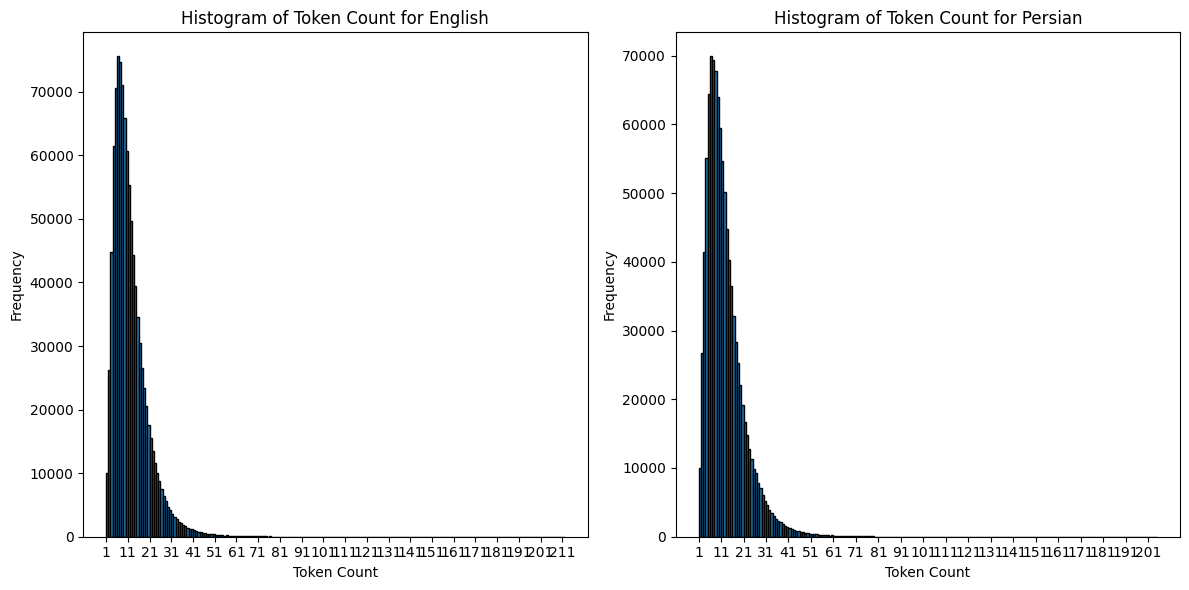

In [7]:
# Create a figure with subplots
plt.figure(figsize=(12, 6))

# Plot histograms using the function
plot_token_count_histogram(df, 'english_token_count', 'English', 121)
plot_token_count_histogram(df, 'persian_token_count', 'Persian', 122)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [8]:
df = df[(df['persian_token_count'] <= 50) & (df['persian_token_count'] >= 10)]

In [9]:
import os

# Define the number of samples for train, test, and evaluation sets
N_TRAIN = 500_000
N_TEST = 10_000
N_EVAL = 5_000

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

# Split the dataframe into train, test, and evaluation sets
train_df = df[:N_TRAIN]
test_df = df[N_TRAIN:N_TRAIN + N_TEST]
eval_df = df[N_TRAIN + N_TEST:N_TRAIN + N_TEST + N_EVAL]

# Define the directory to save the data
SAVE_DIR = 'raw_data'
os.makedirs(SAVE_DIR, exist_ok=True)

In [10]:
# Function to save dataframe columns to CSV
def save_to_csv(dataframe, language, filename):
    filepath = os.path.join(SAVE_DIR, filename)
    dataframe[language].to_csv(filepath, index=False)

In [11]:
# Save the data to CSV files
save_to_csv(train_df, 'persian', 'train.fa')
save_to_csv(train_df, 'english', 'train.en')

save_to_csv(test_df, 'persian', 'test.fa')
save_to_csv(test_df, 'english', 'test.en')

save_to_csv(eval_df, 'persian', 'valid.fa')
save_to_csv(eval_df, 'english', 'valid.en')

## Part 1 - BPE tokenizer training and data preprocessinging the Tokenizer and Preprocessing

In [12]:
if not os.path.exists(f'persian_bpe.model'):
    spm.SentencePieceTrainer.train(
        input=os.path.join(SAVE_DIR, 'train.fa'),
        model_prefix='persian_bpe',
        vocab_size=10000,
        model_type='bpe'
    )
    
print('done')

done


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: raw_data/train.fa
  input_format: 
  model_prefix: persian_bpe
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  

In [13]:
if not os.path.exists(f'english_bpe.model'):
    spm.SentencePieceTrainer.train(
        input=os.path.join(SAVE_DIR, 'train.en'),
        model_prefix='english_bpe',
        vocab_size=10000,
        model_type='bpe'
    )
print('done')

done


sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: raw_data/train.en
  input_format: 
  model_prefix: english_bpe
  model_type: BPE
  vocab_size: 10000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  

In [14]:
persian_tokenizer = spm.SentencePieceProcessor()
persian_tokenizer.load('persian_bpe.model')

persian_tokenizer.encode_as_pieces('سلام دنیا!')

['▁سلام', '▁دنیا', '!']

In [15]:
english_tokenizer = spm.SentencePieceProcessor()
english_tokenizer.load('english_bpe.model')

english_tokenizer.encode_as_pieces('hello world!')

['▁hell', 'o', '▁world', '!']

In [16]:
# Tokenize the columns in the dataframe
def tokenize_column(dataframe, column, tokenizer):
    return dataframe[column].apply(tokenizer.encode_as_pieces)

# Save tokenized columns to CSV
def save_tokenized_to_csv(dataframe, column, filename):
    filepath = os.path.join(TOKENIZED_DIR, filename)
    dataframe[column].to_csv(filepath, index=False)

In [17]:
# Tokenize Persian and English columns for train, test, and evaluation sets
train_df['persian_tokenized'] = tokenize_column(train_df, 'persian', persian_tokenizer)
test_df['persian_tokenized'] = tokenize_column(test_df, 'persian', persian_tokenizer)
eval_df['persian_tokenized'] = tokenize_column(eval_df, 'persian', persian_tokenizer)

train_df['english_tokenized'] = tokenize_column(train_df, 'english', persian_tokenizer)
test_df['english_tokenized'] = tokenize_column(test_df, 'english', persian_tokenizer)
eval_df['english_tokenized'] = tokenize_column(eval_df, 'english', persian_tokenizer)

# Define the directory to save the tokenized data
TOKENIZED_DIR = 'tokenized_data'
os.makedirs(TOKENIZED_DIR, exist_ok=True)

# Save the tokenized data to CSV files
save_tokenized_to_csv(train_df, 'persian_tokenized', 'train.fa')
save_tokenized_to_csv(train_df, 'english_tokenized', 'train.en')

save_tokenized_to_csv(test_df, 'persian_tokenized', 'test.fa')
save_tokenized_to_csv(test_df, 'english_tokenized', 'test.en')

save_tokenized_to_csv(eval_df, 'persian_tokenized', 'valid.fa')
save_tokenized_to_csv(eval_df, 'english_tokenized', 'valid.en')


/tmp/ipykernel_34/2759040184.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['persian_tokenized'] = tokenize_column(train_df, 'persian', persian_tokenizer)
/tmp/ipykernel_34/2759040184.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['persian_tokenized'] = tokenize_column(test_df, 'persian', persian_tokenizer)
/tmp/ipykernel_34/2759040184.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [18]:
!fairseq-preprocess --source-lang en --target-lang fa \
  --testpref tokenized_data/test \
  --trainpref tokenized_data/train --validpref tokenized_data/valid \
  --destdir data-bin --workers 20 \
  --nwordssrc 10000 --nwordstgt 10000

2024-06-15 10:17:17.269106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 10:17:17.269235: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 10:17:17.444755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


## Part 2 - LSTM ENCODER-DECODER model training

In [19]:
!fairseq-train --help

2024-06-15 10:20:41.571861: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 10:20:41.571915: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 10:20:41.573377: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: fairseq-train [-h] [--no-progress-bar] [--log-interval LOG_INTERVAL]
                     [--log-format {json,none,simple,tqdm}]
                     [--log-file LOG_FILE] [--aim-repo AIM_REPO]
                     [--aim-run-hash AIM_RUN_HASH]
                     [--tensorboard-logdir TENSORBOARD_LOGDIR]
                     [--wandb-project WANDB_PROJEC

In [20]:
!fairseq-train data-bin \
  --arch lstm --encoder-bidirectional \
  --max-tokens 5000 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.2 \
  --adam-betas '(0.9, 0.98)' --lr 0.002 \
  --save-dir checkpoints/lstm \
  --optimizer adam \
  --tensorboard-logdir logs/lstm \
  --encoder-layers 6 --decoder-layers 6 \
  --max-epoch 5

2024-06-15 10:21:06.391143: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 10:21:06.391199: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 10:21:06.392670: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 10:21:30.748189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 10:21:30.748242: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factor

## Part 3 - Training the TRANSFORMER ENCODER-DECODER model

In [28]:
!fairseq-train data-bin \
  --arch transformer --encoder-layers 6 --decoder-layers 6 \
  --optimizer sgd --momentum 0.99 --nesterov --lr 0.002 \
  --max-tokens 5000 \
  --criterion label_smoothed_cross_entropy --label-smoothing 0.2 \
  --save-dir checkpoints/transformer \
  --tensorboard-logdir logs/transformer \
  --max-epoch 5

2024-06-15 12:18:42.026935: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:18:42.027019: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:18:42.028572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/opt/conda/bin/fairseq-train", line 5, in <module>
    from fairseq_cli.train import cli_main
  File "/opt/conda/lib/python3.10/site-packages/fairseq_cli/train.py", line 30, in <module>
    from fairseq import checkpoint_utils, options, quantization_utils, tasks, utils
  File "/opt/conda/lib/python3.10/site-packages/fair

## Part 4 - Evaluation criteria and test data review

In [22]:
!fairseq-generate data-bin \
  --beam 5 \
  --batch-size 32 \
  --path checkpoints/lstm/checkpoint_best.pt \
  --remove-bpe > lstm-output.txt

2024-06-15 12:02:21.751383: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:02:21.751441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:02:21.752918: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
  0%|                                                   | 0/314 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [23]:
!fairseq-generate data-bin \
  --beam 5 \
  --batch-size 16 \
  --path checkpoints/transformer/checkpoint_best.pt \
  --remove-bpe > transformer-output.txt

2024-06-15 12:05:38.083471: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 12:05:38.083535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 12:05:38.085062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Traceback (most recent call last):
  File "/opt/conda/bin/fairseq-generate", line 8, in <module>
    sys.exit(cli_main())
  File "/opt/conda/lib/python3.10/site-packages/fairseq_cli/generate.py", line 413, in cli_main
    main(args)
  File "/opt/conda/lib/python3.10/site-packages/fairseq_cli/generate.py", line 50, in main
    return _main(cfg, sys.stdout)
  File 

We'll also use `unbabel-comet` to show the comet metric on out trained models.

In [24]:
!pip install unbabel-comet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 842.1 kB/s eta 0:00:00:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 1.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.0 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.7/529.7 kB 28.0 MB/s eta 0:00:00
DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.2.0
    Uninstalling sentencepiec

In [25]:
def process_fairseq_output(fairseq_output_file, hypothesis_file, source_file, target_file):
    with open(fairseq_output_file, 'r') as infile, open(hypothesis_file, 'w') as hypothesis, open(source_file, 'w') as source, open(target_file, 'w') as target:
        for line in infile:
            line_type, line_content = line[:2], line.split('\t')
            if line_type == 'H-':
                hypothesis.write(line_content[2])
            elif line_type == 'S-':
                source.write(line_content[1])
            elif line_type == 'T-':
                target.write(line_content[1])


In [26]:
process_fairseq_output('lstm-output.txt', 'lstm-hypothesis.txt', 'lstm-source.txt', 'lstm-target.txt')
process_fairseq_output('transformer-output.txt', 'transformer-hypothesis.txt', 'transformer-source.txt', 'transformer-target.txt')

In [30]:
!comet-score -s lstm-source.txt -t lstm-hypothesis.txt -r lstm-target.txt
# !comet-score -s transformer-source.txt -t transformer-hypothesis.txt -r transformer-target.txt

Fetching 5 files: 100%|████████████████████████| 5/5 [00:00<00:00, 50533.78it/s]
/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
Predicting DataLoader 0: 100%|████████████████| 626/626 [13:30<00:00,  1.30s/it]
lstm-hypothesis.txt	Segment 0	score: 0.7294
lstm-hypothesis.txt	Segment 1	score: 0.7718
lstm-hypothesis.txt	Segment 2	score: 0.6528
lstm-hypothesis.txt	Segment 3	score: 0.7013
lstm-hypothesis.txt	Segment 4	score: 0.7173
lstm-hypothesis.txt	Segment 5	score: 0.7424
lstm-hypothesis.txt	Segment 6	score: 0.8175
lstm-hypothesis.txt	Segment 7	score: 0.6612
lstm-hypoth